### Habitat Suitability

&nbsp;

Habitat suitability model predicts the abundance of a certain species in a particular area. Based on the availability of these environmental elements throughout a landscape, the model determines which environmental factors a species prefers or avoids. The result would be an index of habitat suitability based on these factors. The model in this script is listed below.

$$Number of Animals Captured = \alpha + \beta_1 \times Vegetation Type + \beta_2 \times Prey Presence  + \beta_3 \times Altitude $$

where

$\alpha$,$\beta$ denotes the coefficients of the model

In [1]:
import pickle
import sklearn.ensemble
import shapely.geometry
import cv2
import geopandas as gpd
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyodbc
from pyproj import Proj
os.chdir('C:/Users/tm/Downloads/utas/thesis/chapter1/tasmania')

### functions

In [2]:
#coordinates conversion
def convert_easting_northing_to_lat_lon(easting, northing,):
    proj = Proj('+proj=utm +zone=55 +south +ellps=GRS80 +units=m +no_defs')
    lon, lat = proj(easting, northing, inverse=True)
    return lat, lon

In [3]:
#convert asc file to geopandas
def asc2gpd(info,grid):

    #seperate text and int
    info['name']=[i.split(' ')[0] for i in info[0]]
    info['val']=[float(i.split(' ')[-1] )for i in info[0]]

    #convert to int for lower left x,y, nodatavalue and cell size
    xllcorner=info['val'][info['name']=='xllcorner'].item()
    xllcorner=int(xllcorner)
    yllcorner=info['val'][info['name']=='yllcorner'].item()
    yllcorner=int(round(yllcorner))
    cellsize=info['val'][info['name']=='cellsize'].item()
    cellsize=int(cellsize)
    nodataval=info['val'][info['name']=='NODATA_value'].item()
    nodataval=int(nodataval)

    #get coordinates in matrix form
    nrow=range(yllcorner,yllcorner+cellsize*grid.shape[0],cellsize)
    ncol=range(xllcorner,xllcorner+cellsize*grid.shape[1],cellsize)

    #flip y coordinates
    flatarr=[(i,j) for j in nrow for i in ncol]
    y=np.flip(np.array([i[1] for i in flatarr]).reshape(grid.shape),axis=0).flatten().tolist()

    #create geopandas
    export=pd.DataFrame()
    export['coords']=list(zip([i[0] for i in flatarr],y))
    export['altitude']=grid.flatten()
    export['coords'] = export['coords'].apply(shapely.geometry.Point)
    output=gpd.GeoDataFrame(export, geometry='coords')

    #remove nodata point
    output=output[output['altitude']!=nodataval]    
    
    return output

### global variables

In [4]:
lonmin=144.165967
latmin=-43.833736
lonmax=148.576978
latmax=-40.349895
lat_centre =-42.10904672752227 ; lon_centre = 146.6417533511285;
gridlen=35

radius=1.2

### island map

In [5]:
#create map
#alternative projection could be crs4236 wgs84
carte=Basemap(llcrnrlon=lonmin,llcrnrlat=latmin,
              urcrnrlon=lonmax,urcrnrlat=latmax,
              resolution='f', projection='tmerc', 
             lat_0=lat_centre,lon_0=lon_centre,)

carte.drawmapboundary(fill_color='w')
carte.fillcontinents(color='k',lake_color='w')
carte.drawcoastlines()
plt.savefig('./images/base.png',bbox_inches='tight',
                    pad_inches=-.05)
plt.clf()

<Figure size 640x480 with 0 Axes>

In [6]:
#down scale image
baselayer=cv2.imread('./images/base.png',0)
baselayer=cv2.resize(baselayer,dsize=(gridlen,gridlen,),
                   interpolation=cv2.INTER_AREA)
        

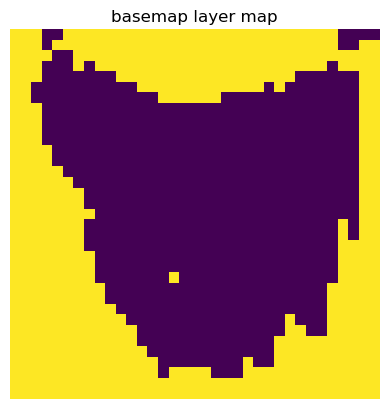

In [7]:
#manual dilution
baselayer[baselayer>=180]=255
baselayer[baselayer<180]=0
plt.imshow(baselayer)
plt.title('basemap layer map')
plt.axis('off')
plt.show()

In [8]:
df_baselayer=pd.DataFrame()
df_baselayer['grid']=baselayer.flatten()
df_baselayer.to_csv('./poems/baselayer.csv',index=False)

### NVA devil

In [9]:
os.chdir('C:/Users/tm/Downloads/utas/WildlifeDatabases')

In [10]:
traphist=pd.DataFrame(columns=['ID', 'TrapID', 'DateOfUse', 'Event', 'CaptureType', 'Microchip',
       'Comment'])

traps=pd.DataFrame(columns=['TrapID', 'Northing', 'Easting', 'Comments', 'TrapLine', 'Researcher'])

for i in ['./crabtree/CBT_database_2022_11_KJS.accdb','./franklin/FRA_database_devil_2022_11_KJS.accdb',
         './woodbridge sandfly/Channel_database_devil_2022_06_KJS.accdb',
           './arthur river/ARV_database_2022_11_CS.accdb','./black river/BRI_database_2022_11_CS.accdb',
         './freycinet/FNP_database_2022_11_KJS.accdb','./takone/TKN_database_2022_11_KJS.accdb',
         './west pencil pine/WPP_September_2022_11_KJS.accdb','./wukalina/Wukalina_NOV2020_SN.accdb',
 './crabtree/CBT_database_2022_11_KJS.accdb','./franklin/FRA_database_devil_2022_11_KJS.accdb',
        ]:

    conn = pyodbc.connect(r'Driver={Microsoft Access Driver (*.mdb, *.accdb)};DBQ='+f'{i};')
    traps=pd.concat([traps,pd.read_sql('select * from traps',conn)])
    traphist=pd.concat([traphist,pd.read_sql('select * from traphistory',conn)])
    traps.reset_index(inplace=True,drop=True)
    traphist.reset_index(inplace=True,drop=True)

C:\Users\tm\AppData\Local\Temp\ipykernel_23820\1571191492.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  traps=pd.concat([traps,pd.read_sql('select * from traps',conn)])
C:\Users\tm\AppData\Local\Temp\ipykernel_23820\1571191492.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  traphist=pd.concat([traphist,pd.read_sql('select * from traphistory',conn)])


In [11]:
#keep useful traps
traps=traps[['TrapID', 'Northing', 'Easting']].drop_duplicates().dropna()

#focus on recapture
traphist=traphist[traphist['Event'].isin(['Tasmanian devil','Tasmanian Devil',])].copy()

#remove null microchip
traphist=traphist.loc[traphist['Microchip'].dropna().index]

#remove duplicates
traphist=traphist.loc[traphist[['Microchip','DateOfUse']].drop_duplicates().index]

In [12]:
#merge
subset=traphist.merge(traps[['TrapID', 'Northing', 'Easting']],on='TrapID',how='left')

#remove empty coordinates
subset=subset.loc[subset[['Northing','Easting']].dropna().index]

In [13]:
subset['Northing']=subset['Northing'].str.replace('5224370.09\r\n5224370.09','5224370.09')
subset['Easting']=subset['Easting'].str.replace('605373\r\n605373','605373')
subset['Easting']=subset['Easting'].str.replace('0\r\n0','0')
subset['Northing']=subset['Northing'].astype(float)
subset['Easting']=subset['Easting'].astype(float)

In [14]:
subset['lat'],subset['lon']=convert_easting_northing_to_lat_lon(subset['Easting'], subset['Northing'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


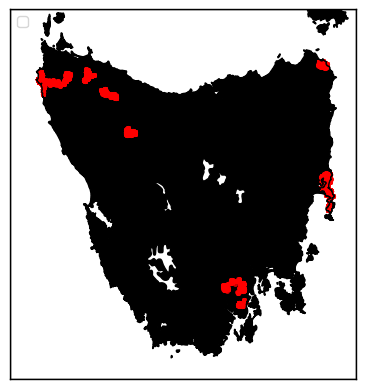

In [15]:
#get channel penninsula
carte=Basemap(llcrnrlon=lonmin,llcrnrlat=latmin,
              urcrnrlon=lonmax,urcrnrlat=latmax,
              resolution='f', projection='tmerc', 
             lat_0=lat_centre,lon_0=lon_centre,)

carte.drawmapboundary(fill_color='w')
carte.fillcontinents(color='k',lake_color='w')
carte.drawcoastlines()
carte.drawrivers()

#differentiate dftd and dft2
x,y=carte(subset['lon'].tolist(),
          subset['lat'].tolist())
plt.scatter(x,y,s=7,c='red',alpha=0.7)


plt.legend()


plt.show()

In [16]:
#locate where the devils are on a 20 by 20 raster
lonunit=(lonmax-lonmin)/gridlen
latunit=(latmax-latmin)/gridlen
subset['lat num']=(subset['lat']-latmin)//latunit
subset['lon num']=(subset['lon']-lonmin)//lonunit
subset['coordinates']=list(zip(subset['lat num'].astype(int),subset['lon num'].astype(int)))

#each individual in a given grid cell counts as one
subset=subset.loc[subset[['Microchip','coordinates']].drop_duplicates().index]

In [17]:
#create matrix
devilcount=subset.groupby(['coordinates']).count()
devil=np.zeros((gridlen,gridlen))
for i in range(len(devilcount)):
    loc=devilcount.index[i]
    if loc[0]>=gridlen or loc[0]<0 or loc[1]>=gridlen or loc[1]<0:
        continue
    devil[loc]=devilcount['Microchip'].iloc[i]

#flip matrix vertically
devil=np.flip(devil,0)

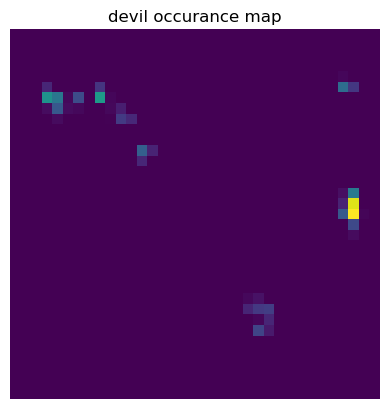

In [18]:
plt.imshow(devil)
plt.title('devil occurance map')
plt.axis('off')
plt.show()

### vegetation

In [19]:
os.chdir('C:/Users/tm/Downloads/utas/tasveg')

In [20]:
#convert stupid utm to lat lon
zips=gpd.read_file('aggr.shp')
# zips.plot()
# plt.title('tasveg')
# plt.xlabel('lon')
# plt.ylabel('lat')
# plt.show()

In [21]:
#crop to island
subset=zips.cx[lonmin:lonmax,
              latmin:latmax]

In [22]:
os.chdir('C:/Users/tm/Downloads/utas/thesis/chapter1/tasmania')

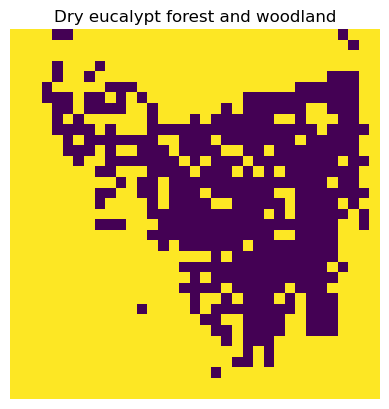

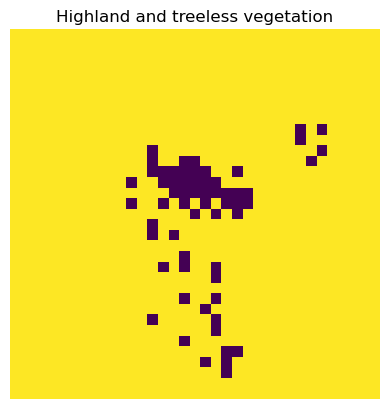

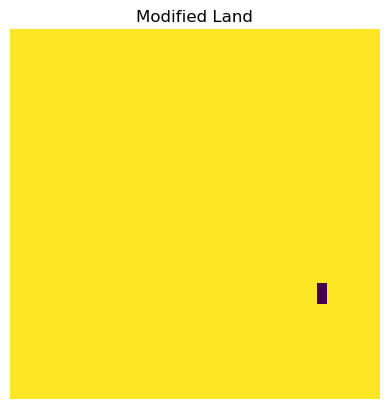

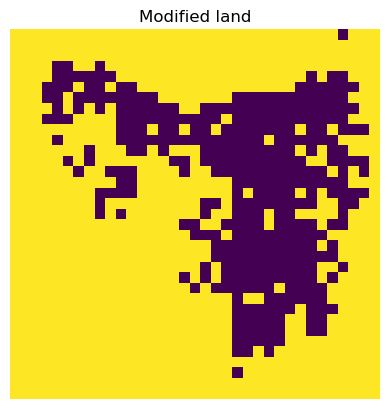

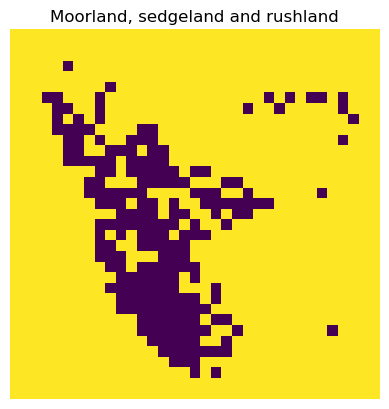

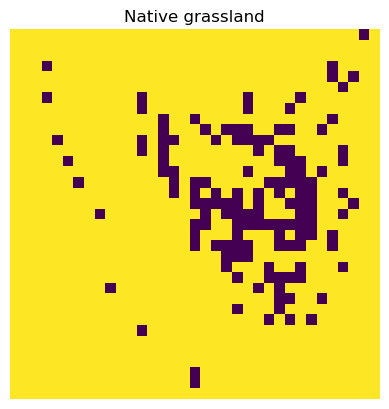

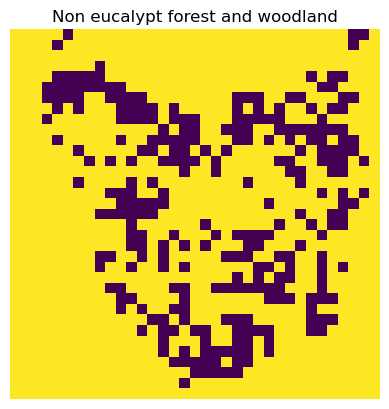

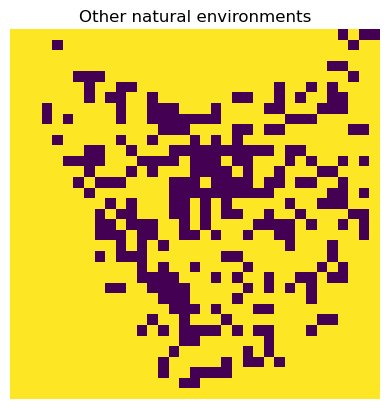

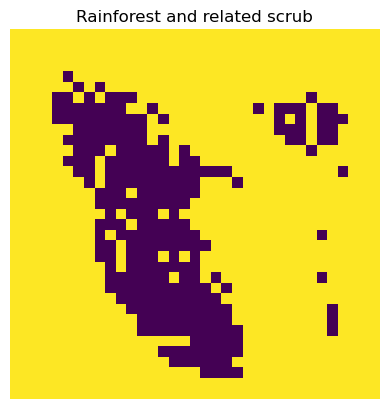

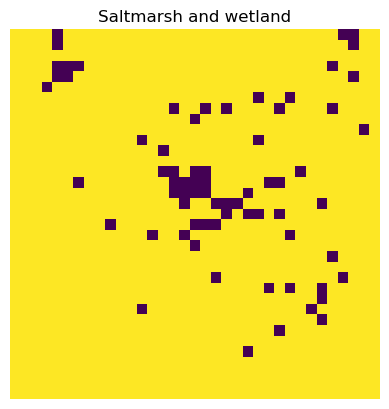

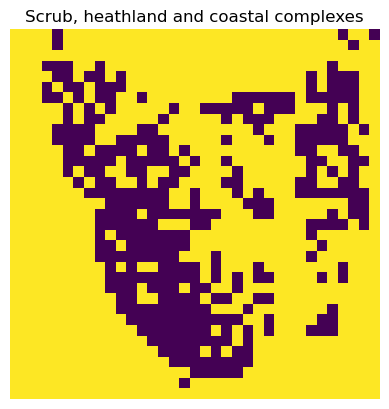

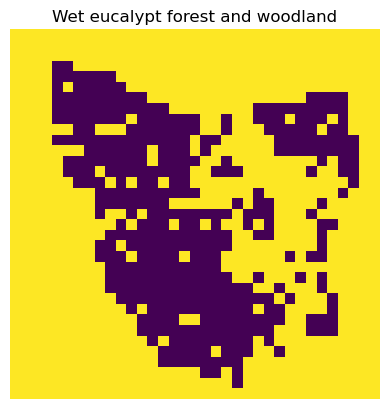

In [23]:
#plot each vegetation type
veg_group={}
for i in subset["VEG_GROUP"].unique():
    subsub=subset[subset["VEG_GROUP"]==i]
    ax=subsub.plot(column="VEG_GROUP")
    ax.set_xlim((lonmin,lonmax))
    ax.set_ylim((latmin,latmax))
    ax.axis('off')    
    plt.savefig(f'./images/{i}.png',bbox_inches='tight',
                    pad_inches=-.05)
    plt.clf()    
    plt.clf()

    #down scale image
    vegtype=cv2.imread(f'./images/{i}.png',0)
    vegtype=cv2.resize(vegtype,dsize=(gridlen,gridlen),
                       interpolation=cv2.INTER_LANCZOS4)
    vegtype[vegtype<255]=0
    veg_group[i]=vegtype
    plt.imshow(veg_group[i])
    plt.title(i)
    plt.axis('off')
    plt.show()

### elevation

In [24]:
#convert coordinates
os.chdir('C:/Users/tm/Downloads/utas/taselevation')
output=pd.read_csv('./height.csv')

In [25]:
output['lat'],output['lon']=convert_easting_northing_to_lat_lon(output['easting'], output['northing'])

In [26]:
lonunit=(lonmax-lonmin)/gridlen
latunit=(latmax-latmin)/gridlen
output['lat num']=(output['lat']-latmin)//latunit
output['lon num']=(output['lon']-lonmin)//lonunit
output['id']=list(zip(output['lat num'].astype(int),output['lon num'].astype(int)))

#compute mean altitude by each cell
height=output[['id','altitude']].groupby('id').mean()['altitude']



In [27]:
#export
os.chdir('C:/Users/tm/Downloads/utas/thesis/chapter1/tasmania')
pd.DataFrame(height).to_csv('height.csv')

height=pd.read_csv('height.csv')

In [28]:
for i in range(len(height)):
    if int(height['id'][i].split(',')[0].split('(')[-1])>=gridlen or \
    int(height['id'][i].split(',')[-1].split(')')[0])>=gridlen or \
    int(height['id'][i].split(',')[0].split('(')[-1])<0 or int(height['id'][i].split(',')[-1].split(')')[0])<0:
        height.drop(i,inplace=True)

In [29]:
#generate raster
altitude=np.zeros(devil.shape)
for i in range(len(height)):
    altitude[eval(height.at[i,'id'])]=height.at[i,'altitude']
altitude=np.flip(altitude,axis=0)

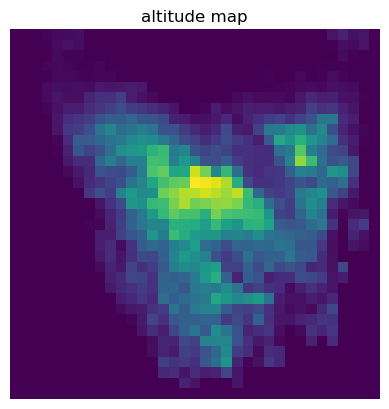

In [30]:
#viz
plt.imshow(altitude)
plt.title('altitude map')
plt.axis('off')
plt.show()

### matrix form

In [31]:
#generate data
data=pd.DataFrame()
data['devil']=devil.flatten()

#create habitat suitability index
#use log to reduce the scale\
data['devil'][data['devil']==0]=np.nan
data['index']=np.log(data['devil']+1)/np.log(data['devil']).max()
arr=altitude.flatten()
data['altitude']=arr

In [32]:
#convert array to binary
arr=baselayer.flatten()
arr[arr==0]=1
arr[arr==255]=0
data['base']=arr

for i in veg_group:
    arr=veg_group[i].flatten()
    arr[arr==0]=1
    arr[arr==255]=0
    data[i]=arr

In [33]:
# #keep channel area and remove the rest
# mask=pd.read_csv('mask.csv',header=None)
# flatmask=np.array(mask).flatten()
# actual_channel_ind=np.where(flatmask==0)[0]


# data['base'].loc[list(set(data[data['base']==1].index).difference(set(actual_channel_ind)))]=0
# data['index'][data['base']==0]=0

### random forest

In [34]:
#remove sea area
land=data[data['base']==1]

#only work on the cells with recorded devil capture
training=land.loc[land['index'].dropna().index]

In [35]:
#train and predict

targets=[i for i in training.columns if i not in ['devil','base','index']]
clf=sklearn.ensemble.RandomForestRegressor()

clf.fit(training[targets],training['index'])

land['pred']=clf.predict(land[targets])

data['pred']=land['pred']

C:\Users\tm\AppData\Local\Temp\ipykernel_23820\3513440024.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  land['pred']=clf.predict(land[targets])


In [36]:
#not bad for scarce data points
clf.score(training[targets],training['index'])

0.8654766867234425

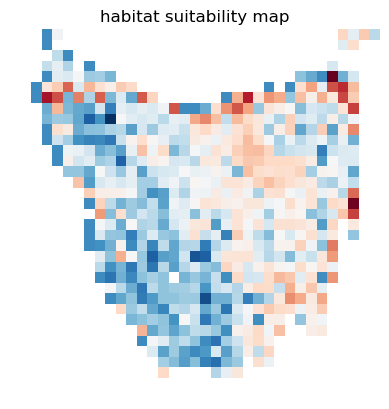

In [37]:
#viz habitat suitability map
plt.imshow(np.array(data['pred']).reshape(gridlen,gridlen),cmap='RdBu_r')
plt.title('habitat suitability map')
plt.axis('off')
plt.show()

In [38]:
land['pred'].loc[land['index'].dropna().index]=land['index'][land['index'].dropna().index].tolist()

C:\Users\tm\AppData\Local\Temp\ipykernel_23820\1000287191.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  land['pred'].loc[land['index'].dropna().index]=land['index'][land['index'].dropna().index].tolist()


In [39]:
land[['pred']].dropna().to_csv('./poems/suitability.csv',index=False)

In [40]:
#create map data
arr=data['base'].to_numpy()
arr[arr==0]=255
arr[arr==1]=0
df_baselayer=pd.DataFrame()
df_baselayer['grid']=arr
df_baselayer.to_csv('./poems/baselayer.csv',index=False)

In [41]:
#convert lattice to adjacency list
check_matrix=arr.reshape(gridlen,gridlen)
adj_list={}

for i in range(gridlen**2):
    current_tile=[i//gridlen,i%gridlen]
    
    if check_matrix[current_tile[0],current_tile[1]]==0:
        adj_list[i]=[]
        
        up=[current_tile[0]-1,current_tile[1]]
        down=[current_tile[0]+1,current_tile[1]]
        left=[current_tile[0],current_tile[1]-1]
        right=[current_tile[0],current_tile[1]+1]

        
        if up[0]>=0 and check_matrix[current_tile[0]-1,current_tile[1]]==0:
            adj_list[i].append(i-gridlen)

        if down[0]<gridlen and check_matrix[current_tile[0]+1,current_tile[1]]==0:
            adj_list[i].append(i+gridlen)
        
        if left[1]>=0 and check_matrix[current_tile[0],current_tile[1]-1]==0:
            adj_list[i].append(i-1)

        if right[1]<gridlen and check_matrix[current_tile[0],current_tile[1]+1]==0:
            adj_list[i].append(i+1)
            

In [42]:
#use bfs to identify the grids required for validation within the radius
counter=0
stop=False
lvl={}
lvl[0]=training[training['index']!=0].index.tolist()
while not stop:
    
    queue=[]
    counter+=1
    if counter>radius:
        stop=True
    for i in list(lvl.values())[-1]:
        queue+=adj_list[i]
    lvl[counter]=list(set(queue))

validation_target=sorted(list(set([j for i in lvl.values() for j in i])))

In [43]:
#create validation area file
valid=pd.DataFrame(index=df_baselayer.index)
valid['target']=0
valid['target'].loc[validation_target]=1
valid.to_csv('./poems/validation.csv',index=False)

In [44]:
#reindex validation area against land area
land['ID']=range(len(land))
identity=pd.DataFrame()
identity['ID']=land['ID'].loc[validation_target].tolist()
identity.to_csv('./poems/identity.csv',index=False)

C:\Users\tm\AppData\Local\Temp\ipykernel_23820\617944699.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  land['ID']=range(len(land))
